## TOC:
* [EDA](#Loading)
* [Continous Feature selection](#Selecting-continous)
* [Cross-Validation dataset](#cross-validation)
* [Logistic Regression tuning](#Logistic)
* [SVM tuning](#SVM)
* [Summary](#Summary)

*Week 4 Assignment*

**EDA and Training Categorization Models**
***Ryan Amundson***

In this notebook, we are starting some explority data anaylsis along with training a logistic regression model. We are also then training a random forest and finally, trying a Catboost categorizion, which is a boosting algorithm that can also handle categorical data. For all of the , I'm attempting to search through some of the hyperparemters with a grid search. 

In the EDA, we also have a lot of features that we can use, so I'm starting with the top 25 based on Chi squared testing. From those I removed the highly correlated features based on the correlation matrix and use the rest to create a test/train set for cross validation. 

For training a model and fitting, I'm doning a grid search for a set of prameters for each model to try to optimize the model fit for each model. There is no Kaggle competition for this data, sadly, so I can only compare AUC and ROC curves for the categorisation data. 


In [12]:
# Imports
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.features import FeatureImportances
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.features import Rank1D, Rank2D
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE


%matplotlib inline

## EDA <a class="anchor" id="Loading"></a>

In [2]:
# Set some options to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


bankDf = pd.read_csv('bankrupt/data.csv')

print("There are {} missing rows in the data".format(sum(bankDf.isna().sum())))

bankCleanDf = bankDf.dropna()

print("There are {} features in the data".format(len(bankCleanDf.columns)))

bankCleanDf.columns

# Clean up the coulm names
bankCleanDf.columns = bankCleanDf.columns.str.strip()

# Find anything that looks like a boolean flag
binaryCats = [col for col in bankCleanDf.columns if len(bankCleanDf[col].unique()) == 2]

print("There are {} binary categories in the data".format(len(binaryCats)))
print("They are {}".format(binaryCats))

print("Types are either {}".format(set(list(bankCleanDf.dtypes))))

# It looks like there is only one boolean flag and then the category we would like to predict, "bankrupt?", all other
# types are floats

columns = set(list(bankCleanDf.columns)) - set(['Bankrupt?'])

There are 0 missing rows in the data
There are 96 features in the data
There are 2 binary categories in the data
They are ['Bankrupt?', 'Liability-Assets Flag']
Types are either {dtype('float64'), dtype('int64')}


In [3]:
bankCleanDf.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

## Continous Features <a class="anchor" id="Selecting-continous"></a>

/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_32965/3704722446.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bankScaledDf = scaler.fit_transform(bankCleanDf[columns].to_numpy())


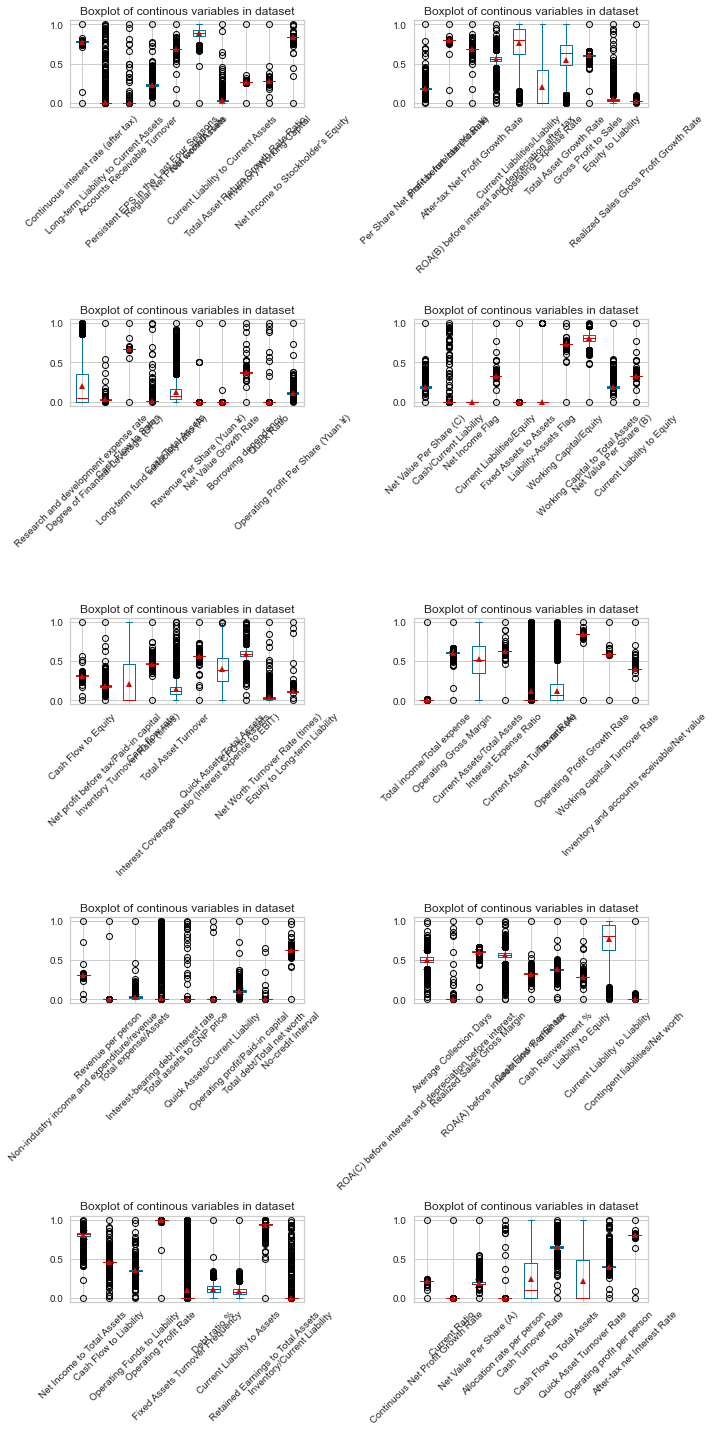

In [4]:
# Lets do a boxblot of all the continous varibles in the dataset to get an idea of what they look like
# Since there are around 100, we can split them into sets of 10. We will also scale them here to normalize 
# all the vsaribles.

scaler = MinMaxScaler()

bankScaledDf = scaler.fit_transform(bankCleanDf[columns].to_numpy())

bankScaledDf = pd.DataFrame(bankScaledDf, columns=columns)

splitColumns = np.array_split(np.asarray(list(columns)), 10);

fig, axs = plt.subplots(5, 2, figsize=(10, 20))

i = 0
for c1, c2 in zip(splitColumns[::2], splitColumns[1::2]):
    bankScaledDf[list(c1)].plot(kind='box', title='Boxplot of continous variables in dataset', showmeans=True, ax=axs[i][0])
    bankScaledDf[list(c2)].plot(kind='box', title='Boxplot of continous variables in dataset', showmeans=True, ax=axs[i][1])
    for t in axs[i][0].get_xticklabels():
        t.set_rotation(45)
    for t in axs[i][1].get_xticklabels():
        t.set_rotation(45)
    i = i + 1

fig.tight_layout()
plt.show()

In [5]:
bankScaledDf["Current Ratio"].unique

<bound method Series.unique of 0       8.214412e-13
1       2.187711e-12
2       4.197292e-12
3       1.525112e-12
4       2.189980e-12
            ...     
6814    3.800187e-12
6815    3.367001e-12
6816    1.397222e-11
6817    4.648177e-12
6818    1.867213e-11
Name: Current Ratio, Length: 6819, dtype: float64>

In [6]:
# Let's take the chi squared top 25 features for feature selection 

selector = SelectKBest(chi2, k=25)
bankScaleTop25df = selector.fit_transform(bankScaledDf[columns], bankCleanDf['Bankrupt?'])

top25Cols = list(bankScaledDf[columns].columns.values[selector.get_support()])

top25Cols

/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_32965/3334794974.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bankScaleTop25df = selector.fit_transform(bankScaledDf[columns], bankCleanDf['Bankrupt?'])
/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_32965/3334794974.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  top25Cols = list(bankScaledDf[columns].columns.values[selector.get_support()])


['Persistent EPS in the Last Four Seasons',
 'Current Liability to Current Assets',
 'Per Share Net profit before tax (Yuan ¥)',
 'ROA(B) before interest and depreciation after tax',
 'Total Asset Growth Rate',
 'Equity to Liability',
 'Cash/Total Assets',
 'Net Value Growth Rate',
 'Quick Ratio',
 'Cash/Current Liability',
 'Fixed Assets to Assets',
 'Liability-Assets Flag',
 'Total Asset Turnover',
 'Quick Assets/Total Assets',
 'Tax rate (A)',
 'Revenue per person',
 'Total expense/Assets',
 'Interest-bearing debt interest rate',
 'Total assets to GNP price',
 'ROA(C) before interest and depreciation before interest',
 'ROA(A) before interest and % after tax',
 'Fixed Assets Turnover Frequency',
 'Debt ratio %',
 'Current Liability to Assets',
 'Quick Asset Turnover Rate']

<AxesSubplot:>

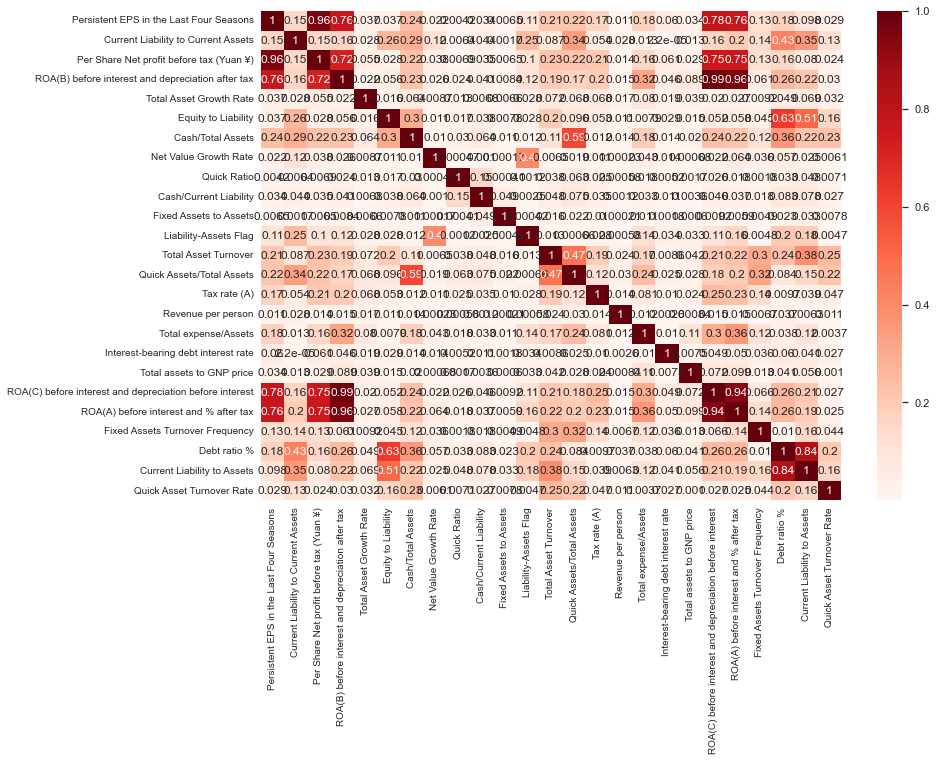

In [7]:
# Lets also do a correlation matrix of the top 25 continous variblss to get an idea of how correlated they are
corrMat = bankScaledDf[top25Cols].corr().abs()

fig, ax = plt.subplots(figsize=(13, 9))
sns.set(font_scale = 1)
sns.heatmap(corrMat, annot=True, cmap="Reds")

In [8]:
# From the correlation matrix, we can see there are few highly correlated features, at around 99%, so let's remove 
# some of those ad then make teat/train set using the rest. 

upper_tri = corrMat.where(np.triu(np.ones(corrMat.shape),k=1).astype(np.bool))

corDrop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

topCats = set(top25Cols) - set(corDrop)

topCats

/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_32965/3973699510.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corrMat.where(np.triu(np.ones(corrMat.shape),k=1).astype(np.bool))


{'Cash/Current Liability',
 'Cash/Total Assets',
 'Current Liability to Assets',
 'Current Liability to Current Assets',
 'Debt ratio %',
 'Equity to Liability',
 'Fixed Assets Turnover Frequency',
 'Fixed Assets to Assets',
 'Interest-bearing debt interest rate',
 'Liability-Assets Flag',
 'Net Value Growth Rate',
 'Persistent EPS in the Last Four Seasons',
 'Quick Asset Turnover Rate',
 'Quick Assets/Total Assets',
 'Quick Ratio',
 'ROA(B) before interest and depreciation after tax',
 'Revenue per person',
 'Tax rate (A)',
 'Total Asset Growth Rate',
 'Total Asset Turnover',
 'Total assets to GNP price',
 'Total expense/Assets'}

## Cross-validation dataset creation <a class="anchor" id="cross-validation"></a>

In [9]:
# Now let's create a test/traing set with those features

X, X_test, y, y_test = train_test_split(bankCleanDf[topCats].copy(), 
                                        bankCleanDf['Bankrupt?'], 
                                        test_size=0.2, 
                                        random_state=42)




/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_32965/4138092390.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X, X_test, y, y_test = train_test_split(bankCleanDf[topCats].copy(),


In [ ]:
#Oversampling the data
smote = SMOTE(random_state=101)
X, y = smote.fit_resample(X, y)

In [10]:
print("Make sure the columns are the same")

assert(len( X.columns) == len(X_test.columns))

Make sure the columns are the same


## Logistic Regression Tuning <a class="anchor" id="Logistic"></a>

Best alpha parameter: {'linear_regression__C': 1.0, 'linear_regression__l1_ratio': 0.9, 'linear_regression__penalty': 'elasticnet', 'linear_regression__solver': 'saga'}


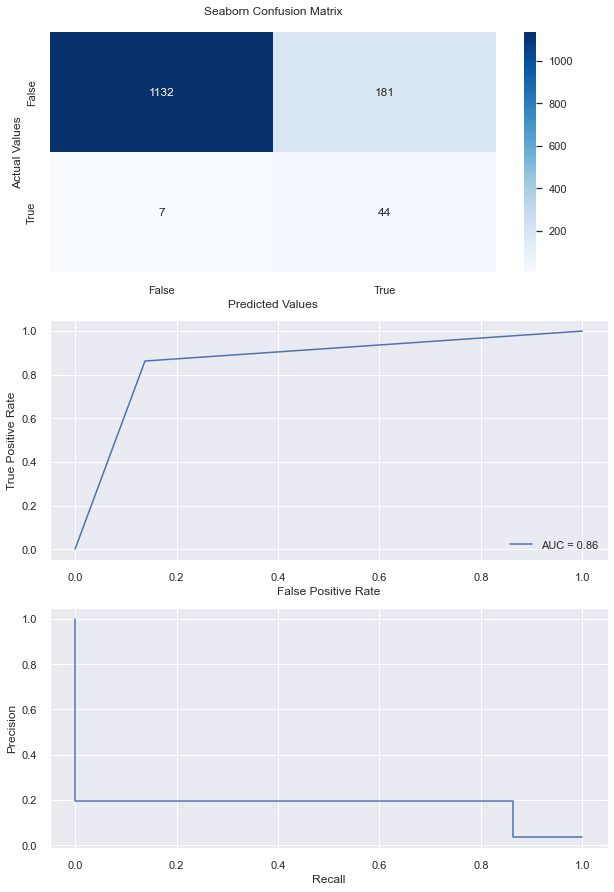

In [13]:
# Becaouse of the massive right skew, lets apply a log transform to normalize the loss data more, and 
# then run a linear model logistic regression on the data to get a baseline

from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

# Some incompatible parameters produce a ton of warnings but then are skipped, lets ignore those for now
import warnings
warnings.filterwarnings("ignore")

# Let's try a series of alphas for parameter tuning
# Along with attempting some parametric pareters and different types of penalties for regularisation
grid = {}
grid['linear_regression__C'] = np.linspace(0.1, 1, num=7)
grid['linear_regression__l1_ratio'] = np.linspace(0.1, 0.9, num=9)
grid['linear_regression__penalty'] = ['elasticnet']
grid['linear_regression__solver'] = ['saga']

linear_regression = LogisticRegression(max_iter=1000)
pipeline = Pipeline([("scaler", MinMaxScaler()),
                    ("linear_regression", linear_regression)])

gscv = GridSearchCV(
                    pipeline, 
                    grid, 
                    scoring='f1', 
                    cv=3,
                    error_score=0.0,
                    n_jobs=4)

l_grid_result = gscv.fit(X, y)
    
l_best_params = l_grid_result.best_params_

print("Best alpha parameter: {}".format(l_best_params))

# prepare the model with target scaling
best_c = l_best_params['linear_regression__C']
best_l1 = l_best_params['linear_regression__l1_ratio']
best_penalty = l_best_params['linear_regression__penalty']
linear_regression =  LogisticRegression(penalty=best_penalty, l1_ratio=best_l1, C=best_c, solver='saga', max_iter=1000)

pipeline = Pipeline([("scaler", MinMaxScaler()),
                    ("linear_regression", linear_regression)])


pipeline.fit(X, y)
y_pred = pipeline.predict(X_test)

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs[0])

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

fpr, tpr, _ = roc_curve(y_test, y_pred, drop_intermediate=False)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))

prec, recall, _ = precision_recall_curve(y_test, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

roc_display.plot(ax=axs[1])
pr_display.plot(ax=axs[2])

## Display the visualization of the Confusion Matrix.
plt.show()


In [14]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred)))

Precicion score: 0.20
Recall score: 0.86
F1 score: 0.32


## SVM Tuning <a class="anchor" id="SVM"></a>

Best parameters: {'linear_regression__C': 5.0, 'linear_regression__degree': 9, 'linear_regression__kernel': 'poly'}


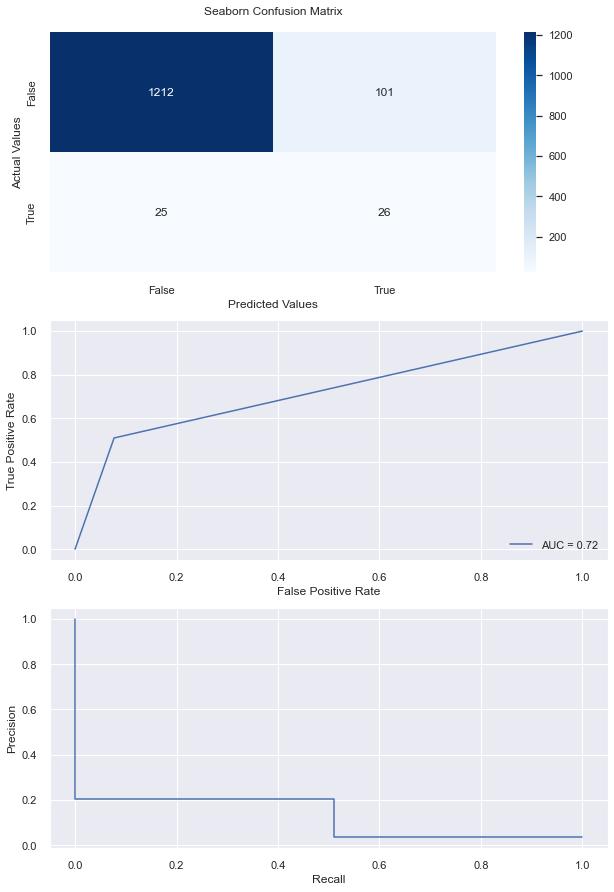

In [15]:
# Next train a SVM model
from sklearn import svm

# Some incompatible parameters produce a ton of warnings but then are skipped, lets ignore those for now
import warnings
warnings.filterwarnings("ignore")


grid = {}
grid['linear_regression__C'] = np.linspace(0.1, 5, num=9)
grid['linear_regression__degree'] = [2,3,5,9,15]
grid['linear_regression__kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']

linear_regression = svm.SVC(max_iter=-1)
pipeline = Pipeline([("scaler", MinMaxScaler()),
                    ("linear_regression", linear_regression)])

gscv = GridSearchCV(
                    pipeline, 
                    grid, 
                    scoring='f1', 
                    cv=3,
                    error_score=0.0,
                    n_jobs=4)

l_grid_result = gscv.fit(X, y)
    
l_best_params = l_grid_result.best_params_

print("Best parameters: {}".format(l_best_params))

# prepare the model with target scaling
best_degree = l_best_params['linear_regression__degree']
best_c = l_best_params['linear_regression__C']
best_kernel = l_best_params['linear_regression__kernel']
linear_regression =  svm.SVC(kernel=best_kernel, C=best_c,
                             degree=best_degree, max_iter=-1)

pipeline = Pipeline([("scaler", MinMaxScaler()),
                    ("linear_regression", linear_regression)])


pipeline.fit(X, y)
y_pred = pipeline.predict(X_test)

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs[0])

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

fpr, tpr, _ = roc_curve(y_test, y_pred, drop_intermediate=False)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))

prec, recall, _ = precision_recall_curve(y_test, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

roc_display.plot(ax=axs[1])
pr_display.plot(ax=axs[2])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred)))

# Ouch, not so great

Precision score: 0.20
Recall score: 0.51
F1 score: 0.29


## Naive Bayes Tuning <a class="anchor" id="NB"></a>

Best parameters: {'linear_regression__alpha': 1e-05}


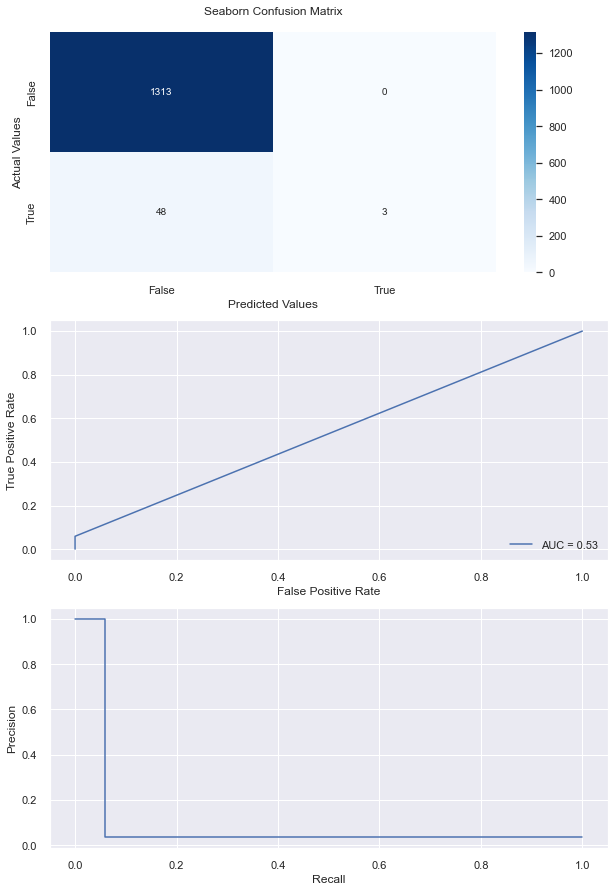

In [15]:
# Finally, train a Nsive Bayes model 
from sklearn.naive_bayes import MultinomialNB

# Some incompatible parameters produce a ton of warnings but then are skipped, lets ignore those for now
import warnings
warnings.filterwarnings("ignore")


grid = {}
grid['linear_regression__alpha'] = np.linspace(0.00001, 2, num=15)

linear_regression = MultinomialNB()
pipeline = Pipeline([("scaler", MinMaxScaler()),
                    ("linear_regression", linear_regression)])

gscv = GridSearchCV(
                    pipeline, 
                    grid, 
                    cv=3,
                    error_score=0.0,
                    n_jobs=4)

l_grid_result = gscv.fit(X, y)
    
l_best_params = l_grid_result.best_params_

print("Best parameters: {}".format(l_best_params))

# prepare the model with target scaling
best_alpha = l_best_params['linear_regression__alpha']
linear_regression =  MultinomialNB(alpha=best_alpha)

pipeline = Pipeline([("scaler", MinMaxScaler()),
                    ("linear_regression", linear_regression)])


pipeline.fit(X, y)
y_pred = pipeline.predict(X_test)

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs[0])

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

fpr, tpr, _ = roc_curve(y_test, y_pred, drop_intermediate=False)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))

prec, recall, _ = precision_recall_curve(y_test, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

roc_display.plot(ax=axs[1])
pr_display.plot(ax=axs[2])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred)))
print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred)))

Precision score: 1.00
Recall score: 0.06
Accuracy score: 0.96
F1 score: 0.11


## Summary <a class="anchor" id="Summary"></a>

The best model of the three was the logistic regression model with an F1 score of 0.23, so still not a great predictor. The other models were worse, with much lower F1 scores. Funny enough, the precision on the naive bayes model was 1, but you can still see it was not a very good model overall with very low recall and f1 scores. 

Since this dataset does not have an associated kaggle competition, I couldn't get a kaggle, athough, I'd be curious at to what it would have been. 
